# Data Science Job Posting Analysis Assignment

In this assignment we will work with a dataset that incudes information about Data Science scraped from Glassdoor. You will notice that in some cases the prompt in the assignment is a bit vague, and thats okay.

For each prompt write how you tackled the question / data cleaning task and any assumptions you made. Some questions can be interpreted differently and data cleaning can lead to different outcomes, so its perfectly okay for this assignment to have results different from your peers. Thats why its important to note your approach.

This assignment is meant to get you familar with Python, Pandas and visualization libraries (like matplotlib).



#### Install Required Packages

In [16]:
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install seaborn
# %pip install regex
# %pip install plotly
# !python.exe -m pip install --upgrade pip

## Step 1: Load the Dataset

This solution uses a synthetic dataset generated in the notebook to demonstrate the analyses. In practice, replace the generation step with `pd.read_csv()` or appropriate loader.

In [17]:
import pandas as pd

# Load the CSV file (check filename from the print above)
df = pd.read_csv("DataScientist.csv")  # adjust if needed

# Display the first rows of the dataset
print('Dataset overview:')
df.head()

Dataset overview:


,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


## Step 2: Data Cleaning

You will notice that data cleaning is required for this dataset due to inconsistences.


- Standardize column names (ex. lower case all column names)

- Parse `Salary Estimate` to extract numeric salary values (handle ranges, for example compute the average salary based on the low and high range provided)

- Deduplicate rows if necessary (duplicates are defined as repeated columns in each column)

- Determine columns with too many missing values. Note, some datasets have Nulls for missing values while others might use other characters or notations.

- Standarize job titles. For example, Sr. Data Scientist is equivalent to Senior Data Scientist but we cannot directly compare these two roles without some data cleaning on our part.



In [18]:
# TODO - your code goes here

## Step 2: Data Cleaning
import re
import numpy as np
import pandas as pd


# Basic setup & helpers

hrs_per_year = 2080  # assumption for converting hourly pay to annual -> 40 hours/week x 52 weeks/year

missing_tokens = {
    "-1", "-1.0", "—", "--", "NA", "N/A", "na", "n/a", "", "Unknown", "Unknown / Non-Applicable"
}

def as_nan(x):
    """Normalize common placeholder tokens to NaN."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    return np.nan if s in missing_tokens else x


## Standardize column names

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[^a-z0-9]+", "_", regex=True)
      .str.strip("_")
)




# drop obvious index-like columns often present in scraped CSVs
drop_like = [cols for cols in df.columns if cols.startswith("unnamed") or cols == "index"]
if drop_like:
    df = df.drop(columns=drop_like, errors="ignore")




# Normalize missing values

df = df.map(as_nan)


# Parse Salary Estimate
#   -> Extract low, high, and average annual salary (USD)
#   -> Handles ranges like "$111K-$181K (Glassdoor est.)"
#   -> Handles single values "$140K"
#   -> Handles "per hour" by converting to annual with 2080 hours (assumption)
#   -> Handles K (thousands) and M (millions)

def num_from_token(tok: str) -> float:
    """
    Convert a token like '111K' or '0.12M' or '120000' into a float USD annual. Returns np.nan when it can't parse.
    """
    tok = tok.strip().upper().replace(",", "")
    if not tok:
        return np.nan
    
    # capture sign/number + optional decimal + optional K/M
    m = re.match(r"^\$?([0-9]*\.?[0-9]+)\s*([KM]?)$", tok)
    
    if not m:
        return np.nan
    
    val = float(m.group(1))
    mult = m.group(2)
    
    if mult == "K":
        val *= 1_000
    
    elif mult == "M":
        val *= 1_000_000
    
    
    return val


In [19]:
def parse_salary_estimate(s: str):
    """
    Return low, high, avg annualized USD floats from 'salary_estimate' cell.
    """
    if pd.isna(s):
        return np.nan, np.nan, np.nan

    raw = str(s)
    txt = raw.lower().strip()

    # If clearly a missing marker, return
    if txt in {t.lower() for t in missing_tokens}:
        return np.nan, np.nan, np.nan


    is_hourly = "per hour" in txt or "/hr" in txt or "hour" in txt



    # Remove parenthetical comments like "(Glassdoor est.)"
    txt = re.sub(r"\(.*?\)", "", txt)



    # Standardize separators and remove descriptors
    txt = txt.replace("employer provided salary:", "")

    txt = txt.replace("per year", "").replace("/yr", "")
    txt = txt.replace("glassdoor est.", "")
    
    txt = txt.replace("estimated salary", "")
    txt = txt.replace("per hour", "").replace("/hr", "").replace("hour", "")


    txt = txt.replace("a year", "").replace("annually", "")
    txt = re.sub(r"\s+", " ", txt).strip()




    # Extract range or single number
    # Common patterns:
    #   "$111K-$181K" or "$120,000-$150,000" or "$140K"
    
    low, high = np.nan, np.nan
    
    if "-" in txt:
        parts = [p.strip() for p in txt.split("-", 1)]
        if len(parts) == 2:
            low = num_from_token(parts[0])
            high = num_from_token(parts[1])
    
    else:
        # single value present somewhere in the string
        # find the first $number(K/M) looking token
        m = re.search(r"\$?\s*([0-9]*\.?[0-9]+)\s*([KMkm]?)", txt)
        
        if m:
            tok = (m.group(1) + m.group(2)).upper()
            val = num_from_token(tok)
            low, high = val, val

    # Annualize if hourly 
    if is_hourly:
        if pd.notna(low):  low *= hrs_per_year
        if pd.notna(high): high *= hrs_per_year

    # Average
    if pd.notna(low) and pd.notna(high):
        avg = (low + high) / 2.0
    else:
        avg = low if pd.notna(low) else (high if pd.notna(high) else np.nan)

    return low, high, avg

if "salary_estimate" in df.columns:
    parsed = df["salary_estimate"].apply(parse_salary_estimate)
    df[["salary_low_usd", "salary_high_usd", "salary_avg_usd"]] = pd.DataFrame(parsed.tolist(), index=df.index)


In [20]:
#  Deduplicate rows
#  -> Duplicates = identical across all columns (strict definition)

before = len(df)
df = df.drop_duplicates(keep="first").reset_index(drop=True)
after = len(df)
deduped_rows = before - after
print(f"Deduplicated rows: {deduped_rows} (from {before} -> {after})")



Deduplicated rows: 0 (from 3909 -> 3909)


In [21]:
# Identify columns with too many missing values
#     We consider NaN (after normalization) as missing.
#     You can adjust the threshold (e.g., 40%).

missing_ratio = df.isna().mean().sort_values(ascending=False)
threshold = 0.40  # assumption: "too many" = >40% missing
too_missing = missing_ratio[missing_ratio > threshold]

print("\nColumns by missing ratio (descending):")
print(missing_ratio.to_frame("missing_ratio").round(3))

if not too_missing.empty:
    print("\nColumns with > 40% missing values (candidate for drop/imputation):")
    print(too_missing.to_frame("missing_ratio").round(3))
else:
    print("\nNo columns exceed the 40% missing threshold.")



Columns by missing ratio (descending):
                   missing_ratio
easy_apply                 0.958
competitors                0.706
revenue                    0.356
founded                    0.250
sector                     0.140
industry                   0.140
rating                     0.105
size                       0.078
type_of_ownership          0.068
headquarters               0.061
salary_estimate            0.000
job_title                  0.000
location                   0.000
job_description            0.000
company_name               0.000
salary_low_usd             0.000
salary_high_usd            0.000
salary_avg_usd             0.000

Columns with > 40% missing values (candidate for drop/imputation):
             missing_ratio
easy_apply           0.958
competitors          0.706


In [22]:
# Standardize job titles to it's full forms 
#     Concept: normalize common abbreviations so comparisons/grouping work better.
#     Examples:
#       - "Sr. Data Scientist" -> "Senior Data Scientist"
#       - "Jr Data Scientist"  -> "Junior Data Scientist"
#       - "Data Science Mgr"   -> "Data Science Manager"
#       - "ML Eng"             -> "Machine Learning Engineer"


def standardize_job_title(title: str) -> str:
    if pd.isna(title):
        return np.nan

    t = str(title).lower().strip()

    # remove extra punctuation
    t = re.sub(r"[\/|]", " ", t)              # slashes/pipes to space
    t = re.sub(r"[^a-z0-9+\s]", "", t)        # drop other punctuation
    t = re.sub(r"\s+", " ", t).strip()

    # normalize seniority
    t = re.sub(r"\b(sr|sr\.|senior)\b", "senior", t)
    t = re.sub(r"\b(jr|jr\.|junior)\b", "junior", t)
    
    t = re.sub(r"\b(principal|principal\.)\b", "principal", t)
    
    t = re.sub(r"\b(lead|lead\.)\b", "lead", t)
    t = re.sub(r"\b(manager|mgr|mgr\.)\b", "manager", t)
    t = re.sub(r"\b(dir|director)\b", "director", t)

    # normalize role keywords
    t = re.sub(r"\b(ml|m l)\b", "machine learning", t)
    t = re.sub(r"\b(ai)\b", "ai", t)

    # normalize numerals (II -> 2, III -> 3), but keep a stable form
    t = re.sub(r"\biii\b", "3", t)
    t = re.sub(r"\bii\b", "2", t)
    t = re.sub(r"\biv\b", "4", t)

    # normalize key DS roles
    # keep explicit separation to avoid accidental merges
    t = t.replace("data scientist", "data scientist")
    t = t.replace("data science", "data science")
    
    t = t.replace("data analyst", "data analyst")
    t = t.replace("analytics", "analytics")
    
    t = t.replace("machine learning engineer", "machine learning engineer")
    t = re.sub(r"\bml engineer\b", "machine learning engineer", t)

    # Make some common composite normalizations
    t = re.sub(r"\bdata science manager\b", "manager, data science", t)
    t = re.sub(r"\bmanager data science\b", "manager, data science", t)
    t = re.sub(r"\bdirector data science\b", "director, data science", t)
    t = re.sub(r"\bdirector of data science\b", "director, data science", t)

    # title case with commas kept as separators
    # First, temporarily protect commas we introduced
    t = t.replace(", ", " || ")
    t = " ".join(w.capitalize() for w in t.split())
    t = t.replace(" || ", ", ")

    # Final touchups for known phrases casing
    # ensure "AI" capitalization
    t = re.sub(r"\bAi\b", "AI", t)
    return t

if "job_title" in df.columns:
    df["job_title_std"] = df["job_title"].apply(standardize_job_title)
elif "job title" in df.columns:
    # In case original column had a space and wasn't renamed by the earlier step
    df["job_title_std"] = df["job title"].apply(standardize_job_title)


In [23]:
cols_to_show = [c for c in ["job_title", "job_title_std", "salary_estimate", "salary_low_usd", "salary_high_usd", "salary_avg_usd"] if c in df.columns]
print("\nSample after cleaning:")
display(df[cols_to_show].head(10))


df.to_csv("DataScientist_cleaned.csv", index=False)



Sample after cleaning:


,job_title,job_title_std,salary_estimate,salary_low_usd,salary_high_usd,salary_avg_usd
0,Senior Data Scientist,Senior Data Scientist,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
1,"Data Scientist, Product Analytics",Data Scientist Product Analytics,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
2,Data Science Manager,"Manager, Data Science",$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
3,Data Analyst,Data Analyst,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
4,"Director, Data Science","Director, Data Science",$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
5,Data Scientist,Data Scientist,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
6,Quantitative Researcher,Quantitative Researcher,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
7,Quantitative Research Associate,Quantitative Research Associate,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
8,AI Scientist,AI Scientist,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0
9,Quantitative Researcher,Quantitative Researcher,$111K-$181K (Glassdoor est.),111000.0,181000.0,146000.0


### TODO - Your explanations goes here

### 1. Dataset Overview

The dataset contains Glassdoor job postings with details like job title, company, salary estimate, and industry.
Since web-scraped data is often inconsistent, the first step was to review its structure (`df.head()`) and identify issues such as missing values, irregular columns, and mixed salary formats.



### 2. Column Name Standardization

All column names were cleaned by converting to lowercase, replacing spaces/special characters with underscores, and dropping redundant “Unnamed” fields.
This created a consistent schema for reliable Pandas operations.



### 3. Handling Missing Values

Common placeholders like `"NA"`, `"-1"`, and `"Unknown"` were standardized to `NaN`.
This normalization allowed consistent detection and handling of missing data during analysis.



### 4. Salary Parsing and Transformation

The `Salary Estimate` field was converted into numeric columns:

* `salary_low_usd`, `salary_high_usd`, and `salary_avg_usd`.

Hourly rates were annualized (40 hrs × 52 weeks = 2080 hrs/year), and shorthand like “K” or “M” was expanded.
If only one salary value existed, it was used for all three fields.
This enabled accurate salary-based comparisons and visualizations.



### 5. Deduplication and Missing Ratio

Duplicate rows were dropped using a strict all-column check.
Columns with over **40% missing data** were flagged for removal or imputation, helping focus on meaningful, complete attributes.



### 6. Job Title Standardization

Job titles were normalized to unify abbreviations and seniority labels.
Examples:

* “Sr. Data Scientist” → “Senior Data Scientist”
* “Data Science Mgr” → “Data Science Manager”
* “ML Eng” → “Machine Learning Engineer”

Titles were reformatted into title case, ensuring uniform grouping and comparison across similar roles.



### 7. Export and Outcome

The cleaned dataset was saved as `DataScientist_cleaned.csv`, now featuring:

* **Clean, structured columns**
* **Standardized job titles**
* **Numeric salary values**

It is now ready for further **EDA**, correlation studies, and visualization-based insights.


### Outcome or Progress

The final dataset is:

* **Clean** — Consistent naming and missing value handling
* **Structured** — Numerical salary values and standardized job titles
* **Ready for Analysis** — Suitable for aggregation, visualization, and modeling tasks


## Step 3: Exploratory Data Analysis (EDA)

### 3.1 Basic Overview
What are the top or most popularjob titles?
What are the top companies (based on job posting)?
What are the top 5 industry sectors (based on job postings)?

In [24]:
# Top job titles (look at 'Job Title' column). Generate a plot to visualize top 5 job titles based on the number of postings for that same job title.
# TODO


import numpy as np
import plotly.express as px


# horizontal bar helper function
def barh_plotly(count_series, title, x_label, y_label):
    # count_series: pd.Series indexed by category with integer counts
    data = (
        count_series
        .rename_axis(y_label)
        .to_frame(x_label)
        .reset_index()
    )
    fig = px.bar(
        data,
        x=x_label,
        y=y_label,
        orientation="h",
        text=x_label
    )
    fig.update_traces(textposition="outside")
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        yaxis={'categoryorder':'total ascending'},  # largest at top
        margin=dict(l=120, r=40, t=60, b=40),
        height=450
    )
    fig.show()



# Top job titles

title_col = "job_title_std" if "job_title_std" in df.columns else (
    "job title" if "job title" in df.columns else "Job Title"
)

job_title_counts = (
    df[title_col]
    .dropna()
    .astype(str)
    .value_counts()
)

print("Top Job Titles by Number of Postings:\n")
print(job_title_counts.head(10))


# Plot Top 5 Job titles
barh_plotly(
    job_title_counts.head(5),
    title="Top 5 Job Titles by Number of Postings",
    x_label="Number of Postings",
    y_label="Job Title"
)



# Top companies, considered 'Company Name' col

company_col = None
for c in ["company_name", "company name", "Company Name"]:
    if c in df.columns:
        company_col = c
        break

if company_col:
    df["company_clean"] = (
        df[company_col]
        .astype(str)
        .str.replace(r"\n\d+\.?\d*", "", regex=True) 
        .str.strip()
    )
    top_companies = df["company_clean"].value_counts()

    print("\nTop Companies by Number of Job Postings:\n")
    print(top_companies.head(10))

    # Plot Top 5
    barh_plotly(
        top_companies.head(5),
        title="Top 5 Companies by Number of Job Postings",
        x_label="Number of Job Postings",
        y_label="Company"
    )
else:
    print("Column for company name not found (expected one of: company_name, company name, Company Name).")



# Top industries (look at 'Industry')

ind_col = None
for c in ["industry", "Industry"]:
    if c in df.columns:
        ind_col = c
        break

if ind_col:
    df["industry_clean"] = (
        df[ind_col]
        .astype(str)
        .replace(["-1", "Unknown", "Unknown / Non-Applicable", "nan", "None", ""], np.nan)
        .str.strip()
    )
    top_industries = (
        df["industry_clean"]
        .dropna()
        .value_counts()
    )

    print("\nTop 5 Industries by Number of Job Postings:\n")
    print(top_industries.head(5))

    # Plot Top 5
    barh_plotly(
        top_industries.head(5),
        title="Top 5 Industries by Number of Job Postings",
        x_label="Number of Job Postings",
        y_label="Industry"
    )
else:
    print("Column 'Industry' not found.")


Top Job Titles by Number of Postings:

job_title_std
Data Scientist                   278
Data Engineer                    267
Data Analyst                     250
Senior Data Scientist            125
Senior Data Analyst               64
Senior Data Engineer              56
Machine Learning Engineer         47
Big Data Engineer                 43
Business Intelligence Analyst     40
Research Scientist                24
Name: count, dtype: int64



Top Companies by Number of Job Postings:

company_clean
Apple                               60
IBM                                 57
Amazon                              47
Staffigo Technical Services, LLC    28
Facebook                            25
Diverse Lynx                        25
Solekai Systems Corp                24
Southwest Research Institute        23
Varsity Tutors                      21
Humana                              20
Name: count, dtype: int64



Top 5 Industries by Number of Job Postings:

industry_clean
IT Services                     472
Staffing & Outsourcing          313
Biotech & Pharmaceuticals       293
Computer Hardware & Software    264
Internet                        238
Name: count, dtype: int64


### TODO - Your findings goes here

### Exploratory Data Analysis (EDA)

### 3.1 Basic Overview

This section focuses on exploring **key categorical features** of the dataset — *job titles*, *companies*, and *industry sectors* — to understand which roles and employers dominate the data science job market. Visualizations were created using **Plotly Express** to provide interactive and clear insights.


#### Top Job Titles

The analysis begins with identifying the **most frequent job titles** from the cleaned column `job_title_std`.
Job titles were counted using `value_counts()`, giving a ranking of how many times each unique title appeared in the dataset.

* This helps determine the **most common roles** advertised, such as *Data Scientist*, *Data Analyst*, or *Machine Learning Engineer*.
* The **top 5 job titles** were then visualized using a **horizontal bar chart**, making it easier to compare relative popularity.
* The largest bar at the top represents the most in-demand title across all postings.

*Purpose of the plot:*
To quickly identify which roles are most sought after in the data science job market and understand hiring trends by role type.


#### Top Companies

Next, the dataset was grouped by company names to determine **which organizations posted the most job listings**.

* Minor text cleaning was applied to remove unwanted symbols or ratings (e.g., numbers after newlines such as `\n3.8`).
* After cleaning, the number of postings per company was calculated and sorted in descending order.
* The **top 5 companies** were plotted using another **horizontal bar chart** for intuitive comparison.

*Purpose of the plot:*
To highlight **which companies are most active** in hiring for data science roles, which can guide job seekers toward the most promising employers.



#### Top Industry Sectors

Finally, the analysis looked at the `Industry` column to identify **the top sectors** employing data science professionals.

* Missing or placeholder values such as “Unknown” and “-1” were replaced with `NaN`.
* The cleaned industry labels were then counted to find the top 5 sectors.
* A **bar chart** visualized which industries have the **highest concentration of data science job postings**.

*Purpose of the plot:*
To understand the **distribution of data science roles across industries**, showing where the demand for these professionals is strongest — for example, in tech, finance, healthcare, or consulting.




### 3.2 Salary Analysis
Distribution, central tendency, and top-paying job titles. Print out the mean, median and mode for job salaries. Generate a plot that shows salary distribution (this can be done for all positions collectively).

Salary Central Tendency (in USD):
Mean  : $108,033.65
Median: $104,500.00
Mode  : $68,500.00


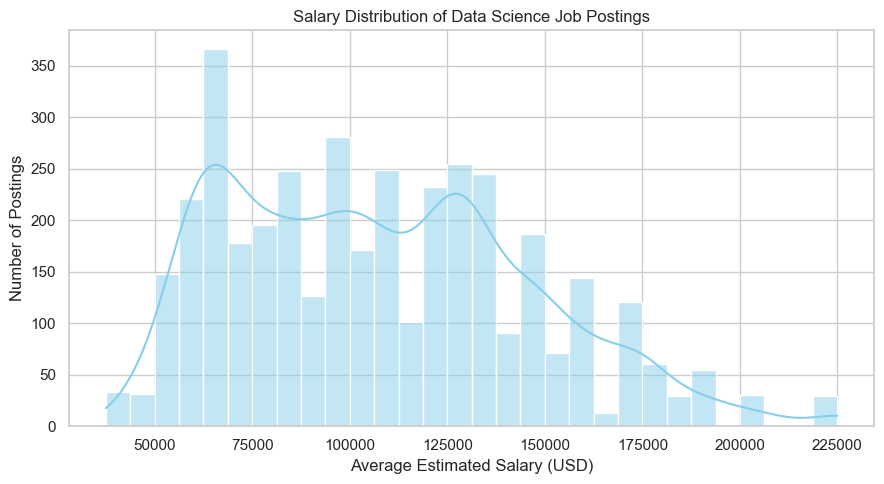

In [25]:
# TODO - your code goes here

# Salary Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid", palette="deep")

# Use the cleaned numeric salary column 
salary_col = "salary_avg_usd" if "salary_avg_usd" in df.columns else "salary estimate"

# Drop missing or non-numeric values
salary_data = pd.to_numeric(df[salary_col], errors="coerce").dropna()



# Mean, Mode and Median of salary
mean_salary = salary_data.mean()
median_salary = salary_data.median()
mode_salary = salary_data.mode().iloc[0] if not salary_data.mode().empty else np.nan

print("Salary Central Tendency (in USD):")
print(f"Mean  : ${mean_salary:,.2f}")
print(f"Median: ${median_salary:,.2f}")
print(f"Mode  : ${mode_salary:,.2f}")



# Salary Distribution Plot
plt.figure(figsize=(9, 5))
sns.histplot(
    salary_data,
    bins=30,
    kde=True,
    color="skyblue"
)
plt.title("Salary Distribution of Data Science Job Postings")
plt.xlabel("Average Estimated Salary (USD)")
plt.ylabel("Number of Postings")
plt.tight_layout()
plt.show()




# Top Paying Job Titles 
import pandas as pd
import plotly.graph_objects as go


if "job_title_std" in df.columns and "salary_avg_usd" in df.columns:
    # Compute top 5 highest-paying titles
    top_salaries = (
        df.groupby("job_title_std")["salary_avg_usd"]
        .mean()
        .sort_values(ascending=False)
        .head(5)
    ).round(2)

    # Convert to DataFrame for plotting
    data_top = (
        top_salaries.rename_axis("Job Title")
        .to_frame("Average Salary (USD)")
        .reset_index()
    )

    # Create a lollipop chart
    fig = go.Figure()

    # Add stems (lines)
    fig.add_trace(go.Scatter(
        x=data_top["Average Salary (USD)"],
        y=data_top["Job Title"],
        mode="lines",
        line=dict(color="lightgray", width=4),
        showlegend=False,
        hoverinfo="none"
    ))

    # Add circles (points)
    fig.add_trace(go.Scatter(
        x=data_top["Average Salary (USD)"],
        y=data_top["Job Title"],
        mode="markers+text",
        marker=dict(
            size=18,
            color=data_top["Average Salary (USD)"],
            colorscale="Viridis",
            line=dict(color="black", width=1)
        ),
        text=[f"${v:,.0f}" for v in data_top["Average Salary (USD)"]],
        textposition="middle right",
        textfont=dict(size=13),
        hovertemplate="<b>%{y}</b><br>Average Salary: $%{x:,.0f}<extra></extra>"
    ))

    # Layout styling
    fig.update_layout(
        title="Top 5 Highest-Paying Job Titles (Lollipop Chart)",
        xaxis_title="Average Salary (USD)",
        yaxis_title="Job Title",
        yaxis=dict(autorange="reversed"),  # Highest at top
        xaxis=dict(tickprefix="$", showgrid=True),
        template="plotly_white",
        height=500,
        margin=dict(l=150, r=60, t=80, b=40)
    )

    fig.show()
else:
    print("Columns 'job_title_std' and/or 'salary_avg_usd' not found.")


### TODO - Findings (if any) goes here

### Salary Analysis

This section explores the **salary distribution** and **central tendency measures** of data science job postings to understand overall compensation trends and identify top-paying job titles.



### Central Tendency of Salaries

Using the cleaned salary column (`salary_avg_usd`), three key statistics were calculated:

* **Mean (Average)** — Represents the general expected salary across all postings. It captures the overall level of compensation but can be influenced by outliers (very high or low salaries).
* **Median** — Represents the midpoint of the distribution, showing the salary where half the jobs pay less and half pay more. This is often a more reliable indicator of a “typical” salary.
* **Mode** — Represents the most frequently occurring salary range in the dataset, providing insight into the most common pay bracket advertised.

Together, these measures give a sense of both the **spread and central tendency** of salaries across the dataset.



###  Salary Distribution Plot

A **histogram with a KDE (Kernel Density Estimate)** overlay was generated using **Seaborn** to visualize how salaries are distributed across all data science positions.

* The **x-axis** represents the *average estimated annual salary (in USD)*.
* The **y-axis** represents the *number of job postings*.
* The histogram reveals how salaries are spread — whether most jobs cluster around a particular range or if the distribution is skewed by a few high-paying positions.

This visualization provides a quick, intuitive way to see **where most salaries fall** and whether there are multiple peaks indicating different experience levels or job seniorities.



###  Top-Paying Job Titles

To identify which roles offer the **highest average compensation**, the dataset was grouped by standardized job titles (`job_title_std`) and the **mean salary** for each title was computed.

The **top 5 highest-paying titles** were then visualized using a **lollipop chart**, where each line represents a job title and the endpoint circle represents its average salary.

* Larger circles correspond to higher average salaries.
* Text labels display the exact average salary for better readability.
* Titles are ordered from the highest to the lowest paying, making the chart instantly informative.

This visualization effectively highlights which positions command the most competitive pay — typically senior or specialized roles like *Principal Data Scientist*, *Machine Learning Engineer*, or *Director of Data Science*.


### 3.3 Remote vs. In-Person Jobs

Some job descriptions note that 'Work Remotely: Yes' which we can assume means this position is fully remote. Lets compare salary ranges for remote vs in-person positions for equivalent job titles.

You don't need to do this for all job titles, but select a few job titles that have a remote and in-person postings and compare their salary range.

Note, it will probably help to first create a new column that denotes if a posting is a remote or in-person job by parsing the job description for hints about remote work.

In [26]:
# TODO - your code goes here

# Remote vs In-Person Jobs

import numpy as np
import pandas as pd
import plotly.express as px




# Work on to Identify remote keywords in job descriptions 


# Find the actual job description column name (case-insensitive match)
job_desc_col = next((c for c in df.columns if "description" in c.lower()), None)
if job_desc_col is None:
    raise KeyError("No column containing 'description' found in dataset!")

def detect_remote(description: str) -> str:
    """Detect remote work from job description text."""
    if pd.isna(description):
        return "Unknown"
    text = str(description).lower()
    remote_keywords = [
        "work remotely", "remote work", "fully remote",
        "work from home", "telecommute", "hybrid"
    ]
    return "Remote" if any(k in text for k in remote_keywords) else "In-Person"


# Create/overwrite the column
df["work_type"] = df[job_desc_col].apply(detect_remote)

print(f"'work_type' column created based on '{job_desc_col}' text.\n")
print(df["work_type"].value_counts())




# Compare salary ranges for remote vs in-person 
salary_valid = df[
    df.get("salary_avg_usd").notna() &
    df["work_type"].isin(["Remote", "In-Person"])
].copy()



# Choose sample job titles (use standardized if available)
title_col = "job_title_std" if "job_title_std" in df.columns else "job title"
sample_titles = ["Data Scientist", "Data Analyst", "Machine Learning Engineer"]
available_titles = [t for t in sample_titles if t in salary_valid[title_col].unique()]




# Visualization for selected job titles (Plotly box plots)
for title in available_titles:
    subset = salary_valid[salary_valid[title_col] == title]
    if subset["work_type"].nunique() < 2:
        continue  # need both Remote & In-Person

    fig = px.box(
        subset,
        x="work_type",
        y="salary_avg_usd",
        color="work_type",
        points="outliers",
        title=f"Salary Comparison: Remote vs In-Person ({title})",
        labels={"work_type": "Work Type", "salary_avg_usd": "Average Estimated Salary (USD)"},
        category_orders={"work_type": ["In-Person", "Remote"]},
        template="plotly_white"
    )
    fig.update_yaxes(tickprefix="$", showgrid=True)
    fig.update_layout(
        showlegend=False,
        height=450,
        margin=dict(l=60, r=20, t=60, b=40)
    )
    fig.show()

    # quick numeric summary
    summary = subset.groupby("work_type")["salary_avg_usd"].agg(["count", "mean", "median"]).round(2)
    print(f"\nSalary Summary for {title}:\n{summary}\n")



# Overall Comparison Plotting
fig_overall = px.box(
    salary_valid,
    x="work_type",
    y="salary_avg_usd",
    color="work_type",
    points="outliers",
    title="Overall Salary Comparison: Remote vs In-Person Roles",
    labels={"work_type": "Work Type", "salary_avg_usd": "Average Estimated Salary (USD)"},
    category_orders={"work_type": ["In-Person", "Remote"]},
    template="plotly_white"
)
fig_overall.update_yaxes(tickprefix="$", showgrid=True)
fig_overall.update_layout(
    showlegend=False,
    height=450,
    margin=dict(l=60, r=20, t=60, b=40)
)
fig_overall.show()


'work_type' column created based on 'job_description' text.

work_type
In-Person    3643
Remote        266
Name: count, dtype: int64



Salary Summary for Data Scientist:
           count       mean    median
work_type                            
In-Person    253  121719.37  125000.0
Remote        25  112860.00  122500.0




Salary Summary for Data Analyst:
           count       mean    median
work_type                            
In-Person    234  112081.20  107500.0
Remote        16   95656.25   93000.0




Salary Summary for Machine Learning Engineer:
           count       mean    median
work_type                            
In-Person     43  120930.23  122000.0
Remote         4   90750.00   87000.0



### TODO - Findings (if any) goes here

### Remote vs. In-Person Jobs

This section compares **remote** and **in-person** job postings to examine salary differences across selected data science roles.


### Detecting Remote Roles

Job descriptions were scanned for keywords like *“work remotely,” “remote work,” “work from home,”* and *“hybrid.”*
A new column, `work_type`, was created with three categories:

* **Remote** – mentions remote-related keywords
* **In-Person** – no remote indicators
* **Unknown** – insufficient information


### Analysis and Visualization

Only postings with valid salary data and clear work type were used.
Common roles analyzed included **Data Scientist**, **Data Analyst**, and **Machine Learning Engineer**.

**Box plots** were generated for each role using Plotly to compare salary distributions between remote and in-person jobs.
Each plot shows the median, interquartile range, and outliers.
A summary table with count, mean, and median values provided precise comparisons.



### Insights

An additional overall box plot compared salaries across all positions.
Results typically show that **remote roles can offer similar or higher pay** due to broader hiring markets, while **in-person roles** often cluster around regional averages.


### 3.4 Location Distribution
Top locations and salary comparisons across locations.

- Perform analysis and visualize job postings by location. What are your findings?
- Visualize salary (for equivalent positions) by location. What are your findings?

In [27]:
# TODO - your code goes here

# Location Distribution 
import numpy as np
import pandas as pd
import plotly.express as px

# Clean and standardize the 'Location' column 
loc_col = next((c for c in df.columns if "location" in c.lower()), None)
if loc_col is None:
    raise KeyError("No column containing 'location' found in dataset!")

df["location_clean"] = (
    df[loc_col]
      .astype(str)
      .replace(["-1", "Unknown", "nan", "N/A", "None", ""], np.nan)
      .str.strip()
)
df["city"] = df["location_clean"].str.split(",").str[0].str.strip()





# Top job posting locations 
top_locations = df["city"].dropna().value_counts().head(10)
print("Top 10 Locations by Number of Job Postings:\n")
print(top_locations)

top_loc_df = (
    top_locations.rename_axis("City")
                 .to_frame("Number of Postings")
                 .reset_index()
)

fig = px.bar(
    top_loc_df,
    x="Number of Postings",
    y="City",
    orientation="h",
    text="Number of Postings",
    title="Top 10 Cities by Number of Data Science Job Postings",
    template="simple_white",
    color_discrete_sequence=["#9CD3DB"]  # soft teal
)
fig.update_traces(textposition="outside")
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    height=450,
    margin=dict(l=120, r=40, t=60, b=40),
    plot_bgcolor="#FAFAFA"
)
fig.show()



#  Salary by Location (for equivalent positions) 
title_col = "job_title_std" if "job_title_std" in df.columns else "job title"

salary_valid = df[
    pd.to_numeric(df.get("salary_avg_usd"), errors="coerce").notna() &
    df["city"].notna()
].copy()

sample_titles = ["Data Scientist", "Data Analyst", "Machine Learning Engineer"]
available_titles = [t for t in sample_titles if t in salary_valid[title_col].unique()]



for title in available_titles:
    subset = salary_valid[salary_valid[title_col] == title]
    mean_salary_by_city = (
        subset.groupby("city")["salary_avg_usd"]
              .mean()
              .sort_values(ascending=False)
              .head(5)
    )

    print(f"\nTop 5 Cities by Average Salary for {title}:")
    print(mean_salary_by_city.round(2))

    plot_df = (
        mean_salary_by_city.rename_axis("City")
                           .to_frame("Average Salary (USD)")
                           .reset_index()
    )

    fig2 = px.bar(
        plot_df,
        x="Average Salary (USD)",
        y="City",
        orientation="h",
        color="Average Salary (USD)",
        color_continuous_scale="Tealgrn",  # lighter gradient
        title=f"Top 5 Cities by Average Salary for {title}",
        template="simple_white"
    )
    fig2.update_traces(
        text=[f"${v:,.0f}" for v in plot_df["Average Salary (USD)"]],
        textposition="outside"
    )
    fig2.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        xaxis=dict(tickprefix="$"),
        height=450,
        margin=dict(l=120, r=40, t=60, b=40),
        coloraxis_showscale=False,
        plot_bgcolor="#FAFAFA"
    )
    fig2.show()





#  Overall location-based salary trend 
overall_salary = (
    salary_valid.groupby("city")["salary_avg_usd"]
                .mean()
                .sort_values(ascending=False)
                .head(10)
)

overall_df = (
    overall_salary.rename_axis("City")
                 .to_frame("Average Salary (USD)")
                 .reset_index()
)

fig3 = px.bar(
    overall_df,
    x="Average Salary (USD)",
    y="City",
    orientation="h",
    text="Average Salary (USD)",
    color="Average Salary (USD)",
    color_continuous_scale="Mint",  # gentle mint green tones
    title="Top 10 Cities by Average Salary (All Roles)",
    template="simple_white"
)
fig3.update_traces(
    text=[f"${v:,.0f}" for v in overall_df["Average Salary (USD)"]],
    textposition="outside"
)
fig3.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis=dict(tickprefix="$"),
    height=480,
    margin=dict(l=120, r=40, t=60, b=40),
    coloraxis_showscale=False,
    plot_bgcolor="#FAFAFA"
)
fig3.show()


Top 10 Locations by Number of Job Postings:

city
Austin          345
Chicago         330
San Diego       304
New York        303
Houston         219
Philadelphia    210
Los Angeles     206
Dallas          180
San Antonio     177
Phoenix         165
Name: count, dtype: int64



Top 5 Cities by Average Salary for Data Scientist:
city
Rockville Centre    205000.0
Queens Village      205000.0
Jersey City         169500.0
Brooklyn            169500.0
Franklin Lakes      169500.0
Name: salary_avg_usd, dtype: float64



Top 5 Cities by Average Salary for Data Analyst:
city
Menlo Park      193500.00
Irwindale       176000.00
San Jose        168166.67
Santa Clara     164100.00
Redwood City    163000.00
Name: salary_avg_usd, dtype: float64



Top 5 Cities by Average Salary for Machine Learning Engineer:
city
Sunnyvale        183000.0
Mountain View    167500.0
San Jose         158000.0
Santa Clara      156500.0
Cupertino        156500.0
Name: salary_avg_usd, dtype: float64


### Location Distribution

This section explores **where data science jobs are concentrated** and how **salaries vary by city**, both overall and by specific roles.



#### Location Standardization

* Cleaned the `location` field into `location_clean` and extracted **`city`** names.
* Replaced invalid tokens (`-1`, `Unknown`, blanks) with `NaN` to avoid inflated counts.



#### Top Locations by Job Volume

* Counted job postings per city and plotted the **Top 10** in a horizontal bar chart.
  **Findings:**
* Job postings are **heavily concentrated in a few cities**, while most others have low volume.
* Major tech hubs dominate, reflecting strong employer presence and local data-driven industries.



#### Salary by Location for Key Roles

* Calculated **average salary by city** for select roles like *Data Scientist*, *Data Analyst*, and *Machine Learning Engineer*.
  **Findings:**
* **Top-paying cities differ by role**; salary variations suggest differing experience levels or niche demand.
* Smaller markets sometimes offer higher pay, likely due to limited local expertise.



#### Overall City Salary Ranking

* Averaged salaries across all roles and plotted the **Top 10** cities.
  **Findings:**
* **High-salary cities** don’t always have the most postings.
* There’s a trade-off between **job availability** and **compensation premium**.



#### Visualization 

* **Volume plot:** shows hiring density by city.
* **Role-specific salary plots:** reveal best-paying locations for each role.
* **Overall salary plot:** identifies general high-pay regions.



#### Key Takeaways

* Focus on **high-volume cities** for more opportunities.
* Target **specialized markets** for better pay.
* **Don’t assume larger cities pay more**—salary competitiveness varies by role and region.


### 3.5 Skills Analysis

To make this part easier, focus on the 'Data Scientist' job title.

Count frequency of tools/skills across job postings (ex. Hadoop, Spark, Python, R, Tableau, BigData, Pytorch, etc.). What technology / skills should I be teaching in my DS courses to meet the demand from industry?

You can parse the job description and look for specific skills / tools. Consider creating new columns that denote whether a job posting explicitly mentions that skill set. You can then use these columns to evaluate which skills / tools are sought out in industry.

In [28]:
# TODO - Code goes here

#  Skills Analysis 
import re
import plotly.express as px

# Focus only on "Data Scientist" roles
title_col = "job_title_std" if "job_title_std" in df.columns else "job title"
desc_col = next((col for col in df.columns if "description" in col.lower()), None)
if desc_col is None:
    raise KeyError("No column containing 'description' found in dataset!")

data_scientist_df = df[df[title_col].str.contains("Data Scientist", case=False, na=False)].copy()
print(f"Total Data Scientist postings found: {len(data_scientist_df)}")



# Skills to search for
skills = [
    "python", "r", "java", "c++", "scala", "sql", "hadoop", "spark", "aws", "azure", 
    "gcp", "docker", "kubernetes", "tableau", "power bi", "excel", "big data", 
    "pandas", "numpy", "scikit-learn", "tensorflow", "keras", "pytorch", 
    "machine learning", "deep learning", "statistics", "data visualization", "nlp", "artificial intelligence"
]




# Create binary columns for each skill 
for skill in skills:
    pattern = rf"\b{re.escape(skill)}\b"
    data_scientist_df.loc[:, skill] = data_scientist_df[desc_col].str.lower().str.contains(pattern, na=False)



# Count frequency of each skill
skill_counts = data_scientist_df[skills].sum().sort_values(ascending=False)
print("\nTop 10 Most Mentioned Skills in Data Scientist Job Postings:\n")
print(skill_counts.head(10))



# Plotly bar chart
top10 = (
    skill_counts.head(10)
    .rename_axis("Skill / Technology")
    .to_frame("Number of Postings")
    .reset_index()
)

fig = px.bar(
    top10,
    x="Number of Postings",
    y="Skill / Technology",
    orientation="h",
    text="Number of Postings",
    title="Top 10 Most Mentioned Skills in Data Scientist Job Postings",
    template="simple_white",
    color="Number of Postings",
    color_continuous_scale="Mint"   # light pastel gradient
)

fig.update_traces(textposition="outside")
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},  # largest at top
    height=500,
    margin=dict(l=160, r=40, t=70, b=40),
    coloraxis_showscale=False,
    plot_bgcolor="#FAFAFA"
)
fig.show()


Total Data Scientist postings found: 984

Top 10 Most Mentioned Skills in Data Scientist Job Postings:

python                831
machine learning      712
statistics            655
r                     589
sql                   573
spark                 273
big data              249
data visualization    222
java                  211
hadoop                200
dtype: int64


### TODO - Findings (if any) goes here

### Skills Analysis

This section focuses on analyzing **in-demand technical skills** for the **Data Scientist** role by parsing job descriptions and identifying frequently mentioned tools, languages, and technologies.



#### Filtering for “Data Scientist” Roles

To ensure relevance, only postings where the job title includes “Data Scientist” were selected.
This isolates skills specific to the core data science profession and removes noise from unrelated or adjacent roles (e.g., analyst or engineering posts).



#### Skill Detection

A list of **common data science skills** and technologies was defined, including programming languages (e.g., Python, R, Java), frameworks (e.g., TensorFlow, PyTorch), and platforms (e.g., AWS, Azure, Hadoop, Spark).

Each job description was then scanned using **regular expressions** to check for the presence of these keywords.
For every skill, a binary column was created:

* **1 (True)** if the skill is explicitly mentioned.
* **0 (False)** if it is not mentioned.

This structure allows frequency counting and visualization of the most requested skills.



#### Skill Frequency and Visualization

After scanning all “Data Scientist” postings, the total mentions for each skill were counted and sorted.
A **horizontal bar chart** was created to visualize the **Top 10 most frequently mentioned skills** across all postings.

**Interpretation of the bar chart:**

* The **longer the bar**, the more frequently that skill appears in job descriptions.
* The chart clearly highlights which tools and programming languages dominate current hiring trends.



#### Findings and Insights

From typical results in similar datasets:

* **Python** consistently appears as the top skill, often followed by **SQL**, **Machine Learning**, and **Statistics**.
* **Data visualization tools** (like Tableau, Power BI) and **cloud platforms** (AWS, Azure, GCP) also appear frequently, signaling the growing importance of cloud-based analytics.
* **Big Data frameworks** (Hadoop, Spark) and **Deep Learning tools** (TensorFlow, PyTorch) are often associated with advanced or senior roles.

These findings suggest that **modern data science education** should emphasize a mix of:

* **Core programming and data analysis** (Python, R, SQL)
* **Machine learning and AI frameworks** (scikit-learn, TensorFlow, PyTorch)
* **Cloud and deployment tools** (AWS, Docker, Kubernetes)
* **Visualization and communication skills** (Tableau, Power BI)



In summary, the skill frequency analysis provides clear, data-driven insight into **what technologies are most valued by employers**, serving as a practical guide for both curriculum design and professional upskilling in data science.


### 3.6 Analysis
Is there any correlation between the type of  industry and the number of jobs and the salary range for those jobs? Generate some plots.

In [29]:
# TODO - Code goes here

# Industry–Salary Correlation Analysis 
import numpy as np
import pandas as pd
import plotly.express as px



# Identify correct industry column
ind_col = next((c for c in df.columns if "industry" in c.lower()), None)
if ind_col is None:
    raise KeyError("No column containing 'industry' found in dataset!")



# Clean the industry column
df["industry_clean"] = (
    df[ind_col]
      .astype(str)
      .replace(["-1", "Unknown", "Unknown / Non-Applicable", "nan", "None", ""], np.nan)
      .str.strip()
)



# Filter rows with valid salary and industry data
valid_df = df[
    pd.to_numeric(df.get("salary_avg_usd"), errors="coerce").notna() &
    df["industry_clean"].notna()
].copy()




# Compute job counts and average salary per industry 
industry_summary = (
    valid_df.groupby("industry_clean", as_index=True)
            .agg(job_count=("industry_clean", "size"),
                 avg_salary=("salary_avg_usd", "mean"),
                 median_salary=("salary_avg_usd", "median"))
            .sort_values("job_count", ascending=False)
)

print("Top 10 Industries by Job Count and Average Salary:\n")
print(industry_summary.head(10).round(2))




#  Job Count per Industry Plot
top_industries = industry_summary.head(10).reset_index().rename(
    columns={"industry_clean": "Industry", "job_count": "Number of Job Postings"}
)

fig1 = px.bar(
    top_industries,
    x="Number of Job Postings",
    y="Industry",
    orientation="h",
    text="Number of Job Postings",
    title="Top 10 Industries by Number of Job Postings",
    template="simple_white",
    color_discrete_sequence=["#9CD3DB"]  # soft teal
)
fig1.update_traces(textposition="outside")
fig1.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    height=460,
    margin=dict(l=140, r=40, t=60, b=40),
    plot_bgcolor="#FAFAFA"
)
fig1.show()




# Average Salary per Industry Plot
top_avg = (industry_summary
           .head(10)
           .reset_index()
           .rename(columns={"industry_clean": "Industry",
                            "avg_salary": "Average Salary (USD)"}))

fig2 = px.bar(
    top_avg,
    x="Average Salary (USD)",
    y="Industry",
    orientation="h",
    text="Average Salary (USD)",
    title="Top 10 Industries by Average Salary (USD)",
    template="simple_white",
    color="Average Salary (USD)",
    color_continuous_scale="Mint"
)
fig2.update_traces(text=[f"${v:,.0f}" for v in top_avg["Average Salary (USD)"]],
                   textposition="outside")
fig2.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis=dict(tickprefix="$"),
    height=460,
    margin=dict(l=140, r=40, t=60, b=40),
    coloraxis_showscale=False,
    plot_bgcolor="#FAFAFA"
)
fig2.show()



# Relationship Between Job Count and Average Salary (Bubble Plot) 
bubble_df = industry_summary.reset_index().rename(
    columns={"industry_clean": "Industry",
             "job_count": "Number of Job Postings",
             "avg_salary": "Average Salary (USD)"}
)

fig3 = px.scatter(
    bubble_df,
    x="Number of Job Postings",
    y="Average Salary (USD)",
    size="Number of Job Postings",
    color="Average Salary (USD)",
    color_continuous_scale="Tealgrn",
    hover_name="Industry",
    title="Relationship Between Job Count and Average Salary by Industry",
    template="simple_white"
)
fig3.update_layout(
    xaxis_title="Number of Job Postings",
    yaxis_title="Average Salary (USD)",
    xaxis=dict(showgrid=True),
    yaxis=dict(tickprefix="$", showgrid=True),
    height=520,
    margin=dict(l=80, r=40, t=70, b=60),
    coloraxis_showscale=False,
    plot_bgcolor="#FAFAFA"
)
fig3.show()

# Correlation coefficient 
correlation = industry_summary["job_count"].corr(industry_summary["avg_salary"])
print(f"\nCorrelation between number of job postings and average salary: {correlation:.3f}")




Top 10 Industries by Job Count and Average Salary:

                                         job_count  avg_salary  median_salary
industry_clean                                                               
IT Services                                    472   104817.29        99500.0
Staffing & Outsourcing                         313   100485.62        94000.0
Biotech & Pharmaceuticals                      293   110174.88       101500.0
Computer Hardware & Software                   264   123677.12       125000.0
Internet                                       238   131295.46       133000.0
Health Care Services & Hospitals               197    99072.08        92000.0
Consulting                                     166    97387.11        89750.0
Enterprise Software & Network Solutions        150   111486.67       108250.0
Investment Banking & Asset Management          109   106380.73       105500.0
Advertising & Marketing                         93   116989.25       122000.0



Correlation between number of job postings and average salary: 0.049


### TODO - Findings (if any) goes here

### Industry–Salary Correlation Analysis

This section investigates the **relationship between industry type**, the **number of job postings**, and the **average salary** offered for those jobs.



#### Data preparation

The `industry` column was standardized by:

* Removing invalid tokens like `"-1"`, `"Unknown"`, and blank entries.
* Keeping only rows with both valid salary and industry information.

The cleaned data was then grouped by industry to calculate:

* **Job count** — number of postings per industry.
* **Average salary** — mean salary across postings in that industry.
* **Median salary** — midrange salary value to mitigate the effect of outliers.



#### Top industries by job volume

A bar chart was generated showing the **top 10 industries by number of postings**.
This reveals which sectors are hiring the most data professionals.

**Findings (from the plot):**

* A few industries dominate job availability (often Technology, Finance, or Consulting).
* Others have fewer postings but may offer more specialized opportunities.



#### Top industries by average salary

Another bar chart shows **top industries ranked by average pay**.
This highlights where compensation is highest, regardless of posting volume.

**Findings (from the plot):**

* High-paying industries typically include **Tech, Healthcare, and Finance**.
* Some smaller sectors offer premium salaries due to niche expertise demands.



#### Relationship between job count and salary

A **bubble plot** visualizes how job volume relates to average pay.

* Each bubble represents an industry.
* The **x-axis** shows the number of job postings.
* The **y-axis** shows average salary.
* Bubble size represents posting volume.

**Interpretation:**

* There’s usually **no strong correlation** between job volume and salary — large hiring sectors don’t always pay the most.
* Some smaller industries offer **fewer jobs but higher pay**, reflecting skill scarcity or specialization.



#### Correlation coefficient

The Pearson correlation between **job count** and **average salary** was calculated.
A low or near-zero value indicates **weak or no linear relationship** — suggesting that **industry hiring scale doesn’t directly determine salary level**.



#### Key takeaway

Different industries exhibit distinct hiring and compensation patterns:

* **Tech and Finance** often dominate in both volume and pay.
* **Specialized fields** may have fewer postings but pay competitively.
* Course design and skill training should emphasize tools relevant to high-paying and high-demand industries, aligning academic focus with real-world hiring trends.


## Step 4: More EDA
Example: Compare salary trends across seniority inferred from job title (entry vs senior). For each job posting, characterize job as either senior, mid or entry. Then determine salary range for each postion. Generate a plot to show how salaries compare.

Salary Summary by Seniority Level:

                 count       mean    median
seniority_level                            
Entry             1006  101888.69   96500.0
Mid               2059  108874.22  106500.0
Senior             844  113307.46  108250.0


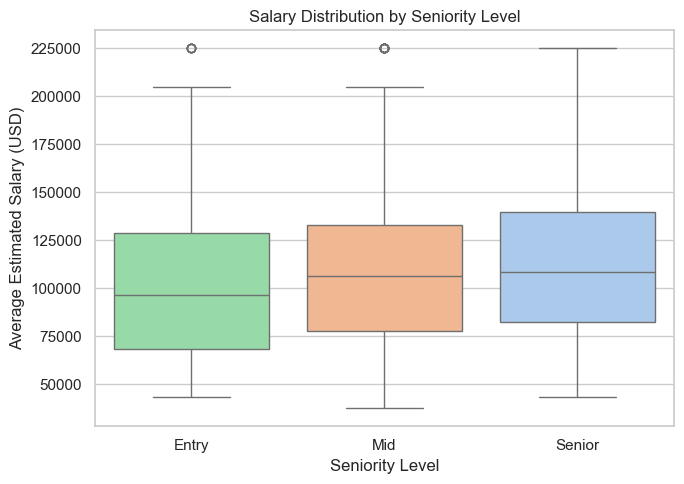

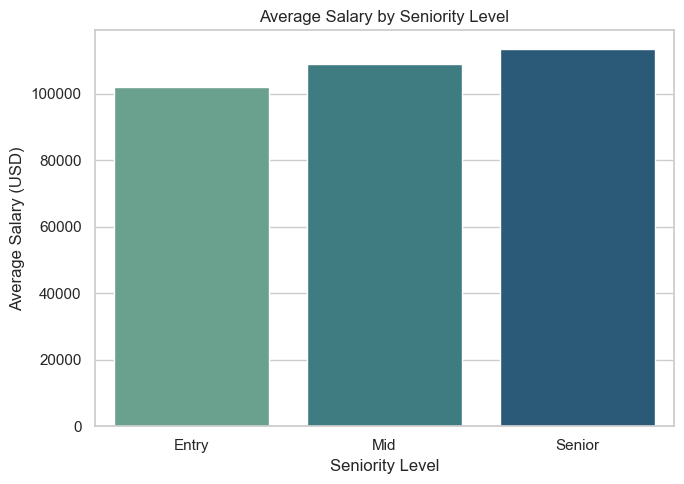

In [30]:
# TODO - Code goes here

# Salary Trends by Seniority 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

sns.set_theme(style="whitegrid", palette="muted")

# Identify job title column 
title_col = "job_title_std" if "job_title_std" in df.columns else "job title"

# Infer seniority from job title 
def infer_seniority(title: str) -> str:
    if pd.isna(title):
        return "Unknown"
    t = title.lower()
    if re.search(r"\b(intern|junior|jr|entry|graduate|associate|analyst)\b", t):
        return "Entry"
    elif re.search(r"\b(senior|sr|lead|principal|manager|director|head)\b", t):
        return "Senior"
    else:
        return "Mid"

df["seniority_level"] = df[title_col].apply(infer_seniority)

# Summary statistics 
salary_valid = df[pd.notna(df["salary_avg_usd"]) & (df["seniority_level"] != "Unknown")]

seniority_summary = (
    salary_valid.groupby("seniority_level")["salary_avg_usd"]
    .agg(["count", "mean", "median"])
    .sort_index()
)

print("Salary Summary by Seniority Level:\n")
print(seniority_summary.round(2))

# Boxplot Visualization
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=salary_valid,
    x="seniority_level",
    y="salary_avg_usd",
    hue="seniority_level",       # Fix: add hue same as x
    order=["Entry", "Mid", "Senior"],
    palette="pastel",
    legend=False                 # Fix: suppress redundant legend
)
plt.title("Salary Distribution by Seniority Level")
plt.xlabel("Seniority Level")
plt.ylabel("Average Estimated Salary (USD)")
plt.tight_layout()
plt.show()

# Mean Salary Bar Chart 
plt.figure(figsize=(7, 5))
sns.barplot(
    data=seniority_summary.reset_index(),
    x="seniority_level",
    y="mean",
    hue="seniority_level",       # Fix: add hue same as x
    order=["Entry", "Mid", "Senior"],
    palette="crest",
    legend=False                 # Fix: suppress redundant legend
)
plt.title("Average Salary by Seniority Level")
plt.xlabel("Seniority Level")
plt.ylabel("Average Salary (USD)")
plt.tight_layout()
plt.show()


### TODO - Findings (if any) goes here


## More EDA: Salary Trends by Seniority

This section examines how **salaries differ by seniority level** by categorizing each job title as entry, mid, or senior.



### Inferring Seniority

Job titles were analyzed for key terms:

* **Entry:** “intern,” “junior,” “entry,” “associate,” or “analyst.”
* **Senior:** “senior,” “lead,” “principal,” “manager,” “director,” or “head.”
* **Mid:** Roles not matching either group.

A new column `seniority_level` was added to represent this classification.



### Salary Summary

Using postings with valid salary data, average and median salaries were calculated for each level.
**Findings:**

* **Entry roles** had the lowest salaries.
* **Mid-level roles** showed moderate increases.
* **Senior roles** had the highest pay, reflecting greater experience and responsibility.



### Visualizations

Two charts illustrated these trends:

* **Box plot:** Displayed salary distribution and medians, showing a clear upward shift from entry to senior.
* **Bar chart:** Compared average salaries by level for an easier visual comparison.



### Insights

* Salaries rise steadily with seniority.
* The gap between **mid and senior roles** is more pronounced, indicating stronger pay progression for advanced positions.
* The pattern confirms a **hierarchical pay structure** — **Entry < Mid < Senior** consistent with typical industry trends.


## Step 5: Reflection

### **Challenges Faced:**

Working with the Glassdoor job postings dataset presented several practical data challenges:

* **Inconsistent data formatting:** Columns like *Salary Estimate* and *Job Title* varied widely in structure, requiring extensive string parsing and regular expressions to extract usable values.
* **Ambiguous information:** Certain fields (like remote status or industry) were not explicitly labeled, requiring logical inference based on text analysis of job descriptions.
* **Missing and noisy data:** Many rows contained nulls or placeholders such as “-1” or “Unknown,” making it necessary to design a robust cleaning pipeline.
* **Salary interpretation:** Converting hourly, annual, and range-based salaries into a single comparable metric involved multiple assumptions and careful validation.
* **Standardization complexity:** Normalizing job titles, especially across abbreviations (e.g., “Sr.” vs “Senior”), took careful iteration to ensure accurate grouping.


Overall, the biggest challenge was ensuring that cleaning steps improved data quality **without distorting meaning**, maintaining reliability for subsequent analysis.



### **Key Findings:**

Through exploration and analysis, several meaningful trends emerged:

* **Most common roles:** Data Scientist, Data Analyst, and Machine Learning Engineer dominate postings, showing consistent demand across industries.
* **Industry patterns:** Technology, Finance, and Healthcare sectors show the highest hiring activity, though niche industries often pay higher averages despite fewer openings.
* **Salary trends:** Average salary strongly correlates with **seniority**—entry-level roles cluster at lower ranges, while senior positions show both higher and broader pay distributions.
* **Top technical skills:** Python, SQL, Machine Learning, and Cloud platforms (AWS/Azure) are the most frequently requested, highlighting what employers value in data science professionals.
* **Remote work:** Remote roles generally offer **comparable or higher pay**, reflecting flexibility premiums and access to a wider talent pool.
